In [1]:
import gym
from gym import spaces
import numpy as np
import pickle

class ClientEnv(gym.Env):
    def __init__(self):
        self.action_space = spaces.Discrete(3) # 3 possible actions
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,)) # 3 observations: profit, time, and number of products
        self.profit = 0 # initial profit is 0
        self.time = 0 # initial time is 0
        self.num_products = 1 # initial number of products is 1
        self.friendly_cost = 100 # cost of being friendly is 100
        self.gift_cost = 500 # cost of sending gifts is 500

    def step(self, action):
        if action == 0: # do nothing
            reward = 0
            cost = 0
        elif action == 1: # be friendly
            self.num_products += 1
            reward = self._get_reward() - self.friendly_cost # subtract the cost of being friendly from the reward
            cost = self.friendly_cost
        elif action == 2: # send gifts
            self.num_products += 2
            reward = self._get_reward() * 2 - self.gift_cost # twice the reward if sending gifts, minus the cost of sending gifts
            cost = self.gift_cost
        self.profit += reward # update the profit with the reward, not subtracting the cost
        self.time += 6 # time step is 6 months
        done = False
        if self.time >= 60: # end of the client's lifetime after 5 years (60 months)
            done = True
        return np.array([self.profit, self.time, self.num_products]), reward, done, {}

    def reset(self):
        self.profit = 0
        self.time = 0
        self.num_products = 1
        return np.array([self.profit, self.time, self.num_products])

    def _get_reward(self):
        mean_reward = self.num_products * 100 # mean reward is proportional to the number of products
        std_reward = self.num_products * 5 # standard deviation is also proportional to the number of products
        reward = np.random.normal(mean_reward, std_reward)
        
        return reward

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import gym

tf.keras.utils.disable_interactive_logging()

class QLearningAgentEpsilonGreedy:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.n_actions = env.action_space.n
        self.input_shape = env.observation_space.shape
        
        with tf.device('/device:GPU:0'):
            self.model = Sequential([
                Dense(32, input_shape=self.input_shape, activation='relu'),
                Dense(32, activation='relu'),
                Dense(self.n_actions, activation=None)
            ])

        self.optimizer = Adam(learning_rate=self.alpha)
        self.model.compile(loss='mse', optimizer=self.optimizer)

    def get_q_values(self, obs):
        with tf.device('/device:GPU:0'):
            return self.model.predict(obs.reshape(1, -1))[0]

    def get_action(self, obs):
        if np.random.uniform() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = self.get_q_values(obs)
            return np.argmax(q_values)

    def update(self, obs, action, reward, next_obs, done):
        q_values = self.get_q_values(obs)
        next_q_values = self.get_q_values(next_obs)

        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(next_q_values)
        
#         td_error = target - q_values[action]
        q_values[action] = target
        with tf.device('/device:GPU:0'):
            self.model.fit(obs.reshape(1, -1), q_values.reshape(1, -1), verbose=False,)

In [3]:
class QLearningAgentSoftmax:
    def __init__(self, env, alpha=0.1, gamma=0.99, temp=1.0):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.q_table = {}
        self.n_actions = env.action_space.n
        self.input_shape = env.observation_space.shape
        
        with tf.device('/device:GPU:0'):
            self.model = Sequential([
                Dense(32, input_shape=self.input_shape, activation='relu'),
                Dense(32, activation='relu'),
                Dense(self.n_actions, activation=None)
            ])

        self.optimizer = Adam(learning_rate=self.alpha)
        self.model.compile(loss='mse', optimizer=self.optimizer)

    def get_q_values(self, obs):
        with tf.device('/device:GPU:0'):
            return self.model.predict(obs.reshape(1, -1))[0]

    def get_action(self, obs):
        q_values = self.get_q_values(obs)
        prob_dist = self.softmax(q_values / self.temp)
        action = np.random.choice(np.arange(self.n_actions), p=prob_dist)
        return action

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def update(self, obs, action, reward, next_obs, done):
        q_values = self.get_q_values(obs)
        next_q_values = self.get_q_values(next_obs)

        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(next_q_values)
        
#         td_error = target - q_values[action]
        q_values[action] = target
        with tf.device('/device:GPU:0'):
            self.model.fit(obs.reshape(1, -1), q_values.reshape(1, -1), verbose=False)

In [4]:
class ExpectedSarsaAgentEpsilonGreedy:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.n_actions = env.action_space.n
        self.input_shape = env.observation_space.shape
        
        with tf.device('/device:GPU:0'):
            self.model = Sequential([
                Dense(32, input_shape=self.input_shape, activation='relu'),
                Dense(32, activation='relu'),
                Dense(self.n_actions, activation=None)
            ])

        self.optimizer = Adam(learning_rate=self.alpha)
        self.model.compile(loss='mse', optimizer=self.optimizer)

    def get_q_values(self, obs):
        with tf.device('/device:GPU:0'):
            return self.model.predict(obs.reshape(1, -1))[0]

    def get_action(self, obs):
        if np.random.uniform() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = self.get_q_values(obs)
            return np.argmax(q_values)

    def update(self, obs, action, reward, next_obs, done):
        q_values = self.get_q_values(obs)
        next_q_values = self.get_q_values(next_obs)

        if done:
            target = reward
        else:
            expected_next_q = np.mean(next_q_values)
            target = reward + self.gamma * expected_next_q
        
#         td_error = target - q_values[action]
        q_values[action] = target
        with tf.device('/device:GPU:0'):
            self.model.fit(obs.reshape(1, -1), q_values.reshape(1, -1), verbose=False,)

In [5]:
class ExpectedSarsaAgentSoftmax:
    def __init__(self, env, alpha=0.1, gamma=0.99, temp=1.0):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.q_table = {}
        self.n_actions = env.action_space.n
        self.input_shape = env.observation_space.shape
        
        with tf.device('/device:GPU:0'):
            self.model = Sequential([
                Dense(32, input_shape=self.input_shape, activation='relu'),
                Dense(32, activation='relu'),
                Dense(self.n_actions, activation=None)
            ])

        self.optimizer = Adam(learning_rate=self.alpha)
        self.model.compile(loss='mse', optimizer=self.optimizer)

    def get_q_values(self, obs):
        with tf.device('/device:GPU:0'):
            return self.model.predict(obs.reshape(1, -1))[0]

    def get_action(self, obs):
        q_values = self.get_q_values(obs)
        prob_dist = self.softmax(q_values / self.temp)
        action = np.random.choice(np.arange(self.n_actions), p=prob_dist)
        return action

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def update(self, obs, action, reward, next_obs, done):
        q_values = self.get_q_values(obs)
        next_q_values = self.get_q_values(next_obs)

        if done:
            target = reward
        else:
            expected_next_q = np.sum(next_q_values * self.softmax(next_q_values))
            target = reward + self.gamma * expected_next_q

#         td_error = target - q_values[action]
        q_values[action] = target
        with tf.device('/device:GPU:0'):
            self.model.fit(obs.reshape(1, -1), q_values.reshape(1, -1), verbose=False)

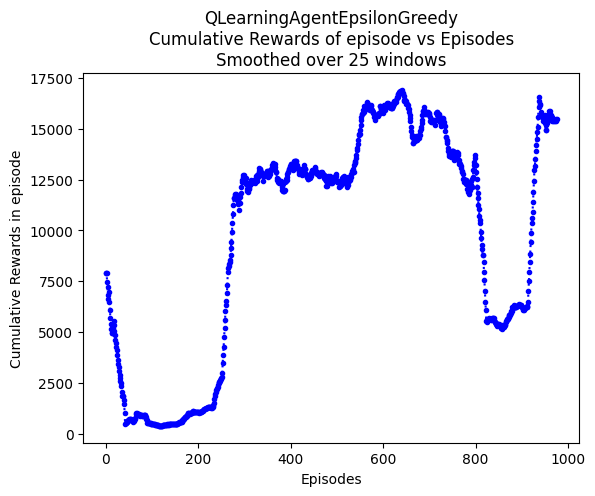

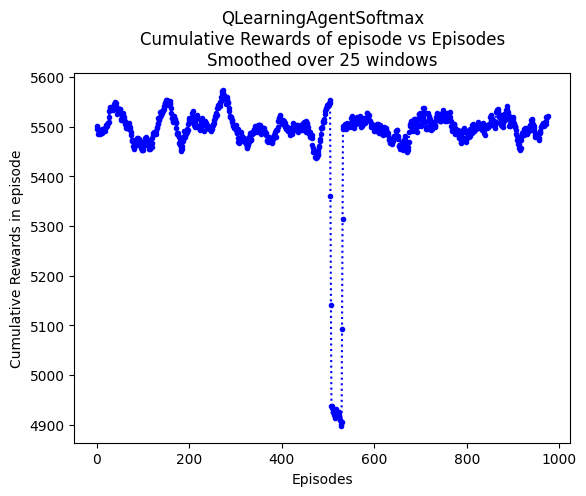

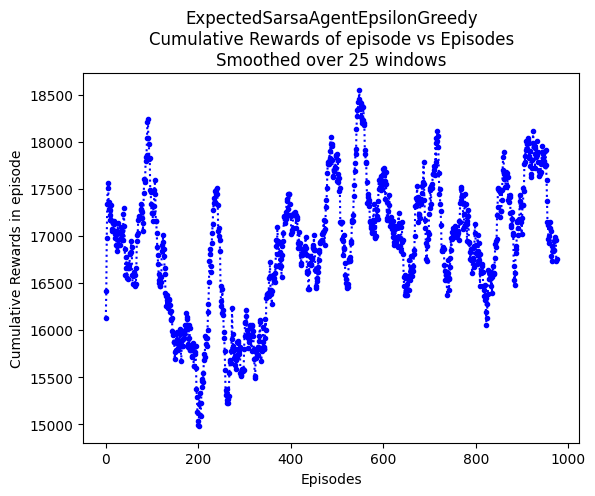

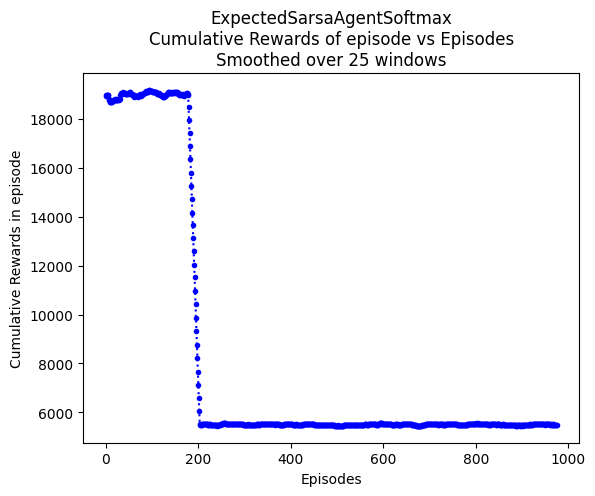

In [6]:
import matplotlib.pyplot as plt
import numpy as np

env = ClientEnv()
algorithms = [QLearningAgentEpsilonGreedy, QLearningAgentSoftmax, ExpectedSarsaAgentEpsilonGreedy, ExpectedSarsaAgentSoftmax]
# algorithms = [ExpectedSarsaAgentSoftmax]

n_episodes = 1000
window_size = 25

# Train q-agent
for algorithm in algorithms:
    agent = algorithm(env)
    cumulative_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        done = False
        cum_reward = 0
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, done, _ = env.step(action)
            agent.update(obs, action, reward, next_obs, done)
            obs = next_obs
            cum_reward += reward
        cumulative_rewards.append(cum_reward)

    # Smooth cumulative rewards over window size
    smoothed_rewards = np.convolve(cumulative_rewards, np.ones(window_size)/window_size, mode='valid')

    # Plot performance
    plt.plot(smoothed_rewards, ':b.')
    plt.title(f"{agent.__class__.__name__}\nCumulative Rewards of episode vs Episodes\nSmoothed over {window_size} windows")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Rewards in episode")
    plt.show()

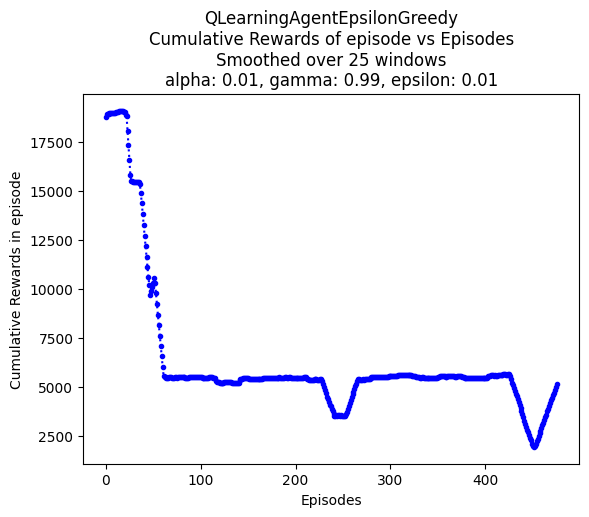

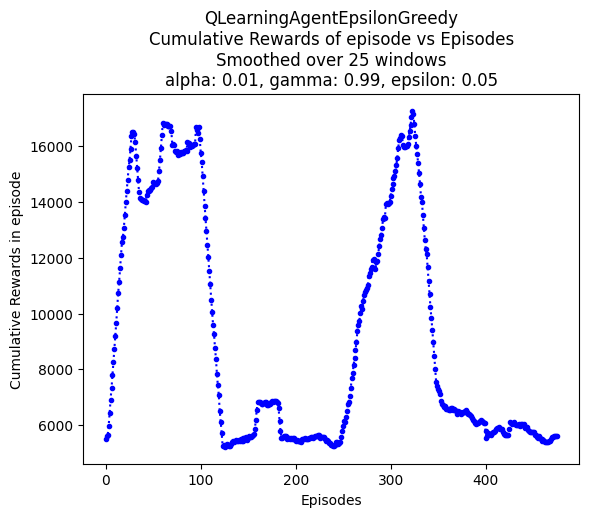

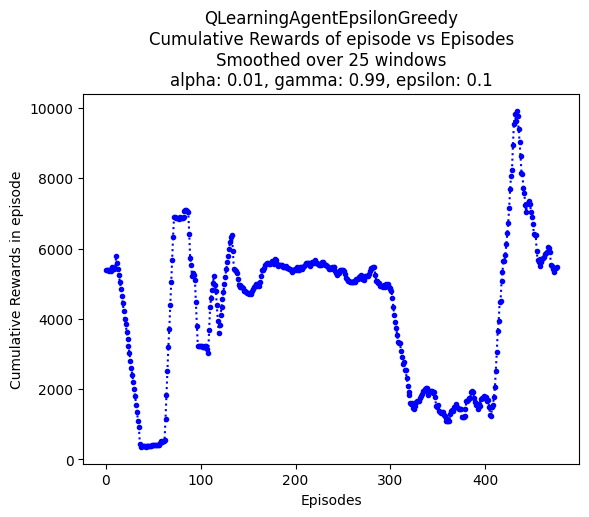

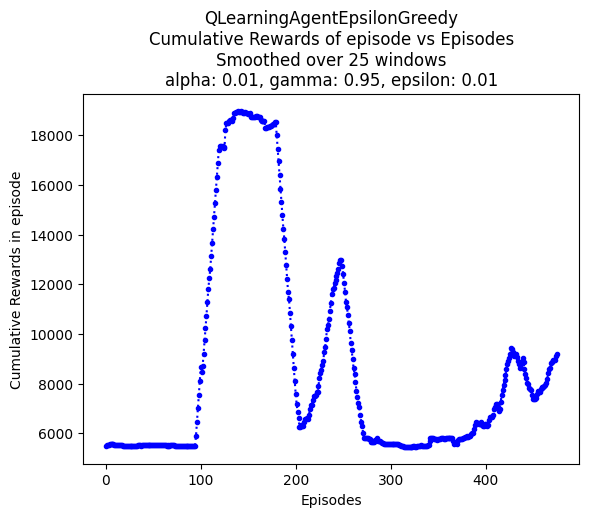

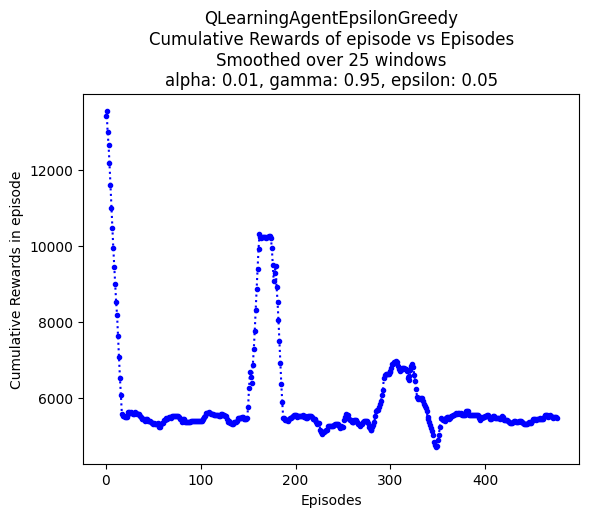

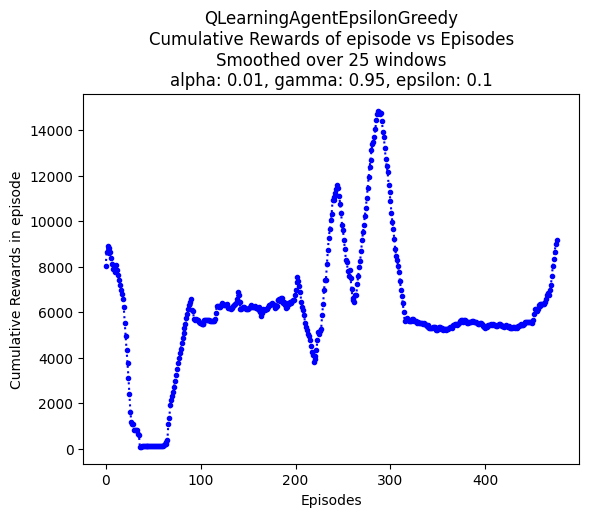

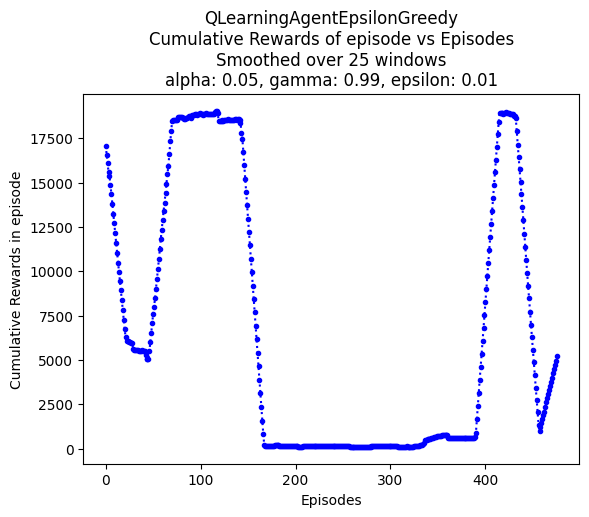

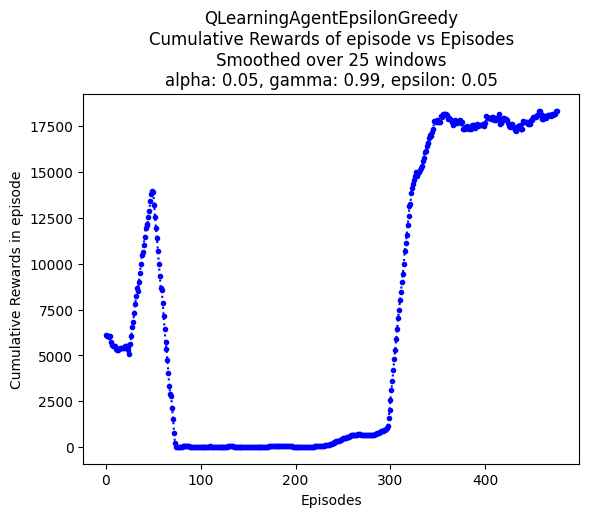

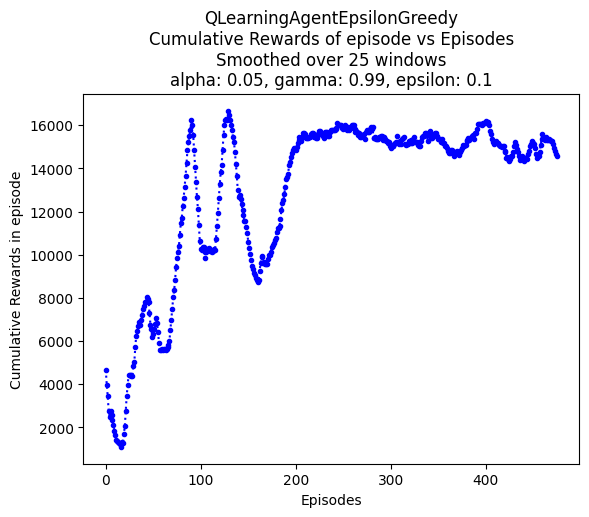

In [ ]:
# ExpectedSarsaAgentSoftmax parameter search

alphas = [0.01, 0.05, 0.1]
gammas = [0.99, 0.95]
epsilons = [0.01, 0.05, 0.1]
n_episodes = 500

for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:

            env = ClientEnv()
            agent = QLearningAgentEpsilonGreedy(env, alpha, gamma, epsilon)

            # Train agent
            cumulative_rewards = []
            for episode in range(n_episodes):
                obs = env.reset()
                done = False
                cum_reward = 0
                while not done:
                    action = agent.get_action(obs)
                    next_obs, reward, done, _ = env.step(action)
                    agent.update(obs, action, reward, next_obs, done)
                    obs = next_obs
                    cum_reward += reward
                cumulative_rewards.append(cum_reward)

            # Smooth cumulative rewards over window size
            smoothed_rewards = np.convolve(cumulative_rewards, np.ones(window_size)/window_size, mode='valid')

            # Plot performance
            plt.plot(smoothed_rewards, ':b.')
            plt.title(f"{agent.__class__.__name__}\nCumulative Rewards of episode vs Episodes\nSmoothed over {window_size} windows\nalpha: {alpha}, gamma: {gamma}, epsilon: {epsilon}")
            plt.xlabel("Episodes")
            plt.ylabel("Cumulative Rewards in episode")
            plt.show()

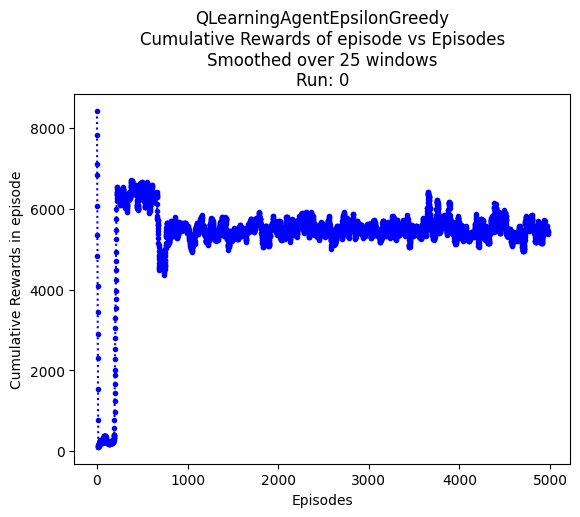

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

env = ClientEnv()
# algorithms = [QLearningAgentEpsilonGreedy, QLearningAgentSoftmax, ExpectedSarsaAgentEpsilonGreedy, ExpectedSarsaAgentSoftmax]
algorithms = [ExpectedSarsaAgentSoftmax]

n_episodes = 5000
n_runs = 5
window_size = 25

# Train q-agent
for algorithm in algorithms:
    for run in range(n_runs):
        agent = QLearningAgentEpsilonGreedy(env, 0.05, 0.99, 0.1)
        cumulative_rewards = []
        for episode in range(n_episodes):
            obs = env.reset()
            done = False
            cum_reward = 0
            while not done:
                action = agent.get_action(obs)
                next_obs, reward, done, _ = env.step(action)
                agent.update(obs, action, reward, next_obs, done)
                obs = next_obs
                cum_reward += reward
            cumulative_rewards.append(cum_reward)

        # Smooth cumulative rewards over window size
        smoothed_rewards = np.convolve(cumulative_rewards, np.ones(window_size)/window_size, mode='valid')

        # Plot performance
        plt.plot(smoothed_rewards, ':b.')
        plt.title(f"{agent.__class__.__name__}\nCumulative Rewards of episode vs Episodes\nSmoothed over {window_size} windows\nRun: {run}")
        plt.xlabel("Episodes")
        plt.ylabel("Cumulative Rewards in episode")
        plt.show()